In [ ]:
## Inference

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries, concatenate
from darts.models import TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mse, rmse
from darts.datasets import EnergyDataset
import warnings
import pickle
warnings.filterwarnings('ignore')

# Helper function for model configuration
def generate_torch_kwargs():
    return {
        'pl_trainer_kwargs': {
            'accelerator': 'cpu',
        }
    }


In [25]:

# Your CSV data as a string
# Convert CSV to DataFrame
df = pd.read_csv('data/energy_dataset.csv')

# Convert DataFrame to JSON, preserving the date format
json_data = df.to_json(date_format='iso', orient='records')

# Save JSON data to a file
json_file_path = 'energy_data.json'
with open(json_file_path, 'w') as file:
    file.write(json_data)

# Function to read the saved JSON data back into a DataFrame
def read_data_from_json(file_path):
    df = pd.read_json(file_path, convert_dates=['time'])
    df['time'] = pd.to_datetime(df['time'])  # Ensure the 'time' column is in datetime format
    df.set_index('time', inplace=True)  # Set the 'time' column as the index
    return df

# Use the function to read the data
df_from_json = read_data_from_json(json_file_path)
# df_from_json.resample('D').mean()
# Showing the first few rows of the DataFrame to verify
# df_from_json.head()

In [26]:
# Load the scaler object back from the file

def preprocess_val(scaler,df):
    '''
    '''
    df_day_avg = df.resample('D').mean()
    series = TimeSeries.from_dataframe(df_day_avg, value_cols=['generation hydro run-of-river and poundage'])

    # Splitting the series into training and validation sets, with the split point chosen
    # to ensure the model is trained on a substantial historical dataset while leaving
    # enough recent data for validation.
    train, val = series.split_after(pd.Timestamp('20170901'))

    # Normalize the series to aid the model training process by ensuring numerical values
    # have a mean of 0 and standard deviation of 1. This helps improve the stability and
    # speed of convergence during training.
    val_transformed = scaler.transform(val)

    # Add day as a covariate:
    # Including the day of the month as a one-hot encoded covariate to provide the model
    # with additional contextual information about potential daily periodicities in
    # hydroelectric generation.
    day_series = datetime_attribute_timeseries(series, attribute='day', one_hot=True)
    return val, day_series
scaler_file_path='scaler.pkl'
with open(scaler_file_path, 'rb') as file:
    scaler_loaded = pickle.load(file)
# Example: Transforming new validation data with the reloaded scaler
val_transformed, day_series = preprocess_val(scaler_loaded,df_from_json)

In [27]:
# df_from_json.index=df['time']

In [28]:
# df_from_json

In [29]:
# Configure and train the TCN model
model = TCNModel(
    input_chunk_length=365,
    output_chunk_length=7,
    n_epochs=50,
    dropout=0.2,
    dilation_base=2,
    kernel_size=5,
    num_filters=8,
    random_state=0,
    **generate_torch_kwargs()
)
model.load_weights('models/TCN_model.pt')

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

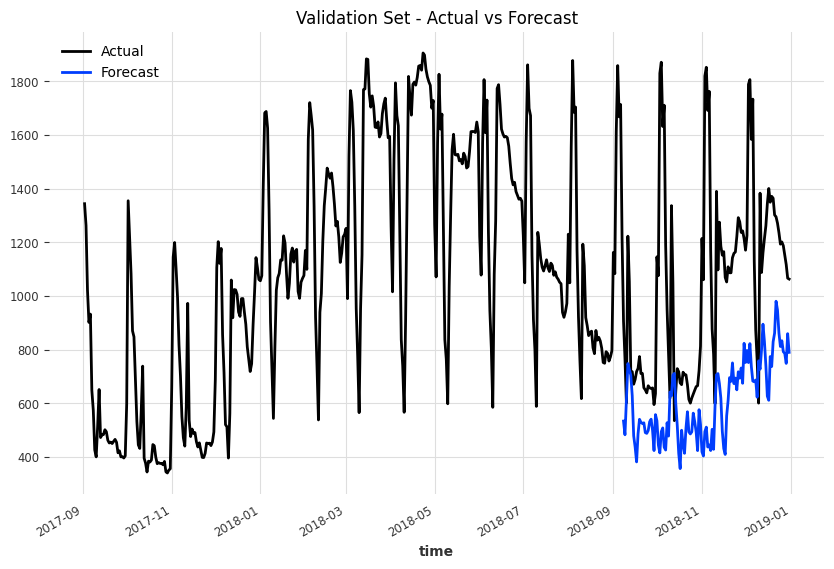

In [30]:
backtest = model.historical_forecasts(
    series=val_transformed,
    past_covariates=day_series,
    forecast_horizon=7,
    retrain=False,
    verbose=True
)

# Plotting actual vs forecasted
plt.figure(figsize=(10, 6))
val_transformed.plot(label='Actual')
backtest.plot(label='Forecast')
plt.legend()
plt.title('Validation Set - Actual vs Forecast')
plt.show()

In [35]:
backtest.__to_csv

AttributeError: 'TimeSeries' object has no attribute '__to_csv'